# CoordConv experiments - Supervised Coordinate Classification
*Notebooks to reproduce [CoordConv paper](https://arxiv.org/abs/1807.03247) using PyTorch framework and [Ignite](https://github.com/pytorch/ignite)*

This notebook describes coordinate classification task: given an `(x, y)` coordinate as input, a network must learn to paint the correct output pixel. 
We compare classical deconvolutional network and a network with CoordConv.

Implementation of CoordConv is taken from [mkocabas/CoordConv-pytorch](https://github.com/mkocabas/CoordConv-pytorch) (thanks to @mkocabas)

## 0. Not-so-Clevr toy dataset

In [1]:
from notsoclevr import NotSoClevr


ds = NotSoClevr()

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

def to_img(t):
    return 255 * t.numpy()[0, :, :]

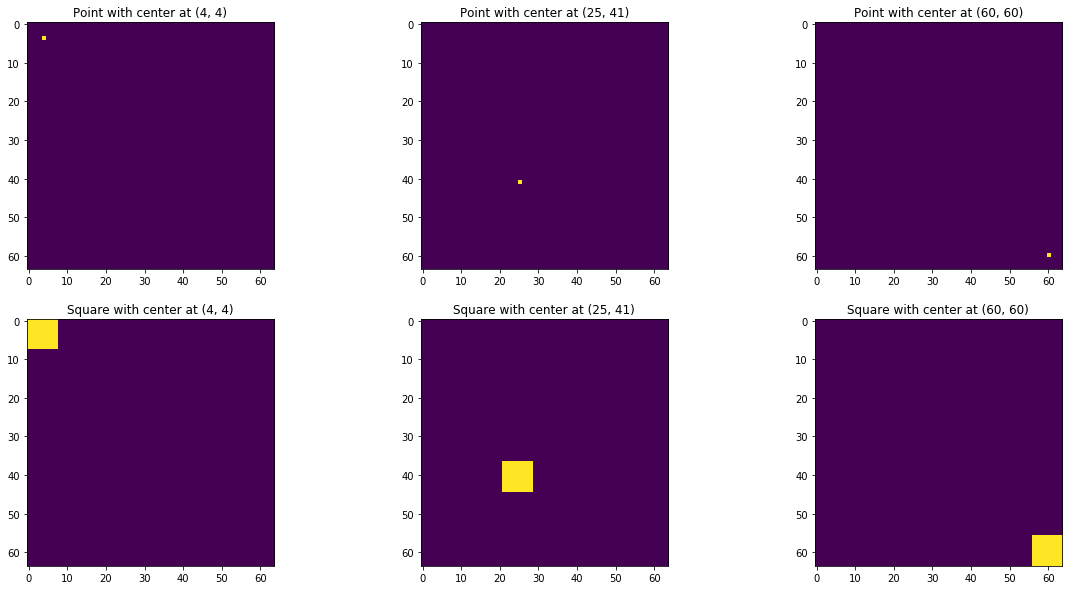

In [3]:
plt.figure(figsize=(20, 10))

c, p, im = ds[0]
plt.subplot(231)
plt.title("Point with center at {}".format(c))
plt.imshow(to_img(p))
plt.subplot(234)
plt.title("Square with center at {}".format(c))
plt.imshow(to_img(im))

c, p, im = ds[1234]
plt.subplot(232)
plt.title("Point with center at {}".format(c))
plt.imshow(to_img(p))
plt.subplot(235)
plt.title("Square with center at {}".format(c))
plt.imshow(to_img(im))

c, p, im = ds[-1]
plt.subplot(233)
plt.title("Point with center at {}".format(c))
plt.imshow(to_img(p))
plt.subplot(236)
plt.title("Square with center at {}".format(c))
plt.imshow(to_img(im))

Train/Test splits:
- random split
- quadrant split

In [4]:
import torch

seed = 12
_ = torch.manual_seed(seed)

In [5]:
size = len(ds)

random_indices = torch.randperm(size)
train_split = int(0.75 * size)

train_random_indices = random_indices[:train_split]
test_random_indices = random_indices[train_split:]

train_random_indices.shape, test_random_indices.shape

(torch.Size([2436]), torch.Size([813]))

In [6]:
train_quadrant_indices = []
test_quadrant_indices = []

for i, (c, p, im) in enumerate(ds):
    if c[0] > ds.canvas_size * 0.5 and \
        c[1] > ds.canvas_size * 0.5:
        test_quadrant_indices.append(i)
    else:
        train_quadrant_indices.append(i)

train_quadrant_indices = torch.tensor(train_quadrant_indices)
test_quadrant_indices = torch.tensor(test_quadrant_indices)

In [7]:
index = 0
sum_train_random_points = ds[train_random_indices[index]][1]
for index in range(1, len(train_random_indices)):
    sum_train_random_points += ds[train_random_indices[index]][1]
    
index = 0
sum_test_random_points = ds[test_random_indices[index]][1]
for index in range(1, len(test_random_indices)):
    sum_test_random_points += ds[test_random_indices[index]][1]
    
index = 0
sum_train_quad_points = ds[train_quadrant_indices[index]][1]
for index in range(1, len(train_quadrant_indices)):
    sum_train_quad_points += ds[train_quadrant_indices[index]][1]
    
index = 0
sum_test_quad_points = ds[test_quadrant_indices[index]][1]
for index in range(1, len(test_quadrant_indices)):
    sum_test_quad_points += ds[test_quadrant_indices[index]][1]

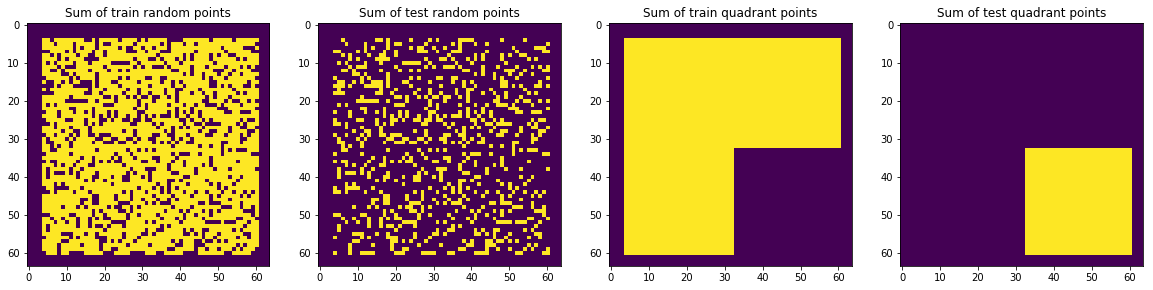

In [8]:
plt.figure(figsize=(20, 10))

plt.subplot(141)
plt.title("Sum of train random points")
plt.imshow(to_img(sum_train_random_points))

plt.subplot(142)
plt.title("Sum of test random points")
plt.imshow(to_img(sum_test_random_points))

plt.subplot(143)
plt.title("Sum of train quadrant points")
plt.imshow(to_img(sum_train_quad_points))

plt.subplot(144)
plt.title("Sum of test quadrant points")
plt.imshow(to_img(sum_test_quad_points))

## 1. Supervised Coordinate Classification

Given an `(x, y)` coordinate as input, a network must learn to paint the correct output pixel. This is simply a multi-class classification problem where each pixel is a class.

In [9]:
from utils import logits_to_img, logits_to_index, normalize

### Model with deconvolutions

Following S1 of the paper, we defines a similar network with deconvolutions

In [10]:
import torch.nn as nn
from torch.nn import functional as F


class ClassicDeconvNet(nn.Module):
    
    def __init__(self, fs=2, c=1):
        super(ClassicDeconvNet, self).__init__()
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2, 64 * c, kernel_size=(fs, fs), stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64 * c, 64 * c, kernel_size=(fs, fs), stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64 * c, 64 * c, kernel_size=(fs, fs), stride=2),
            nn.ReLU(),

            nn.ConvTranspose2d(64 * c, 32 * c, kernel_size=(fs, fs), stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32 * c, 32 * c, kernel_size=(fs, fs), stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32 * c, 1, kernel_size=(fs, fs), stride=2)            
        )
        
    def forward(self, x):
        return self.net(x)


#### Random train/test split

In [11]:
classic_net = ClassicDeconvNet()

x = torch.rand(4, 2, 1, 1)
y = classic_net(x)
y.shape

torch.Size([4, 1, 64, 64])

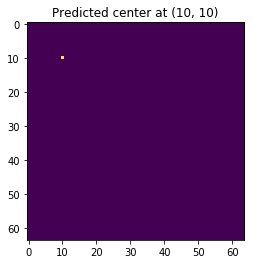

In [12]:
plt.title("Predicted center at {}".format(logits_to_index(y[1, :, :, :], ds.canvas_size)))
plt.imshow(logits_to_img(y[1, :, :, :]))

In [13]:
from utils import TransformedDataset


def unsqueeze(x):    
    return torch.tensor(x, dtype=torch.float32).unsqueeze(dim=-1).unsqueeze(dim=-1)


def point_to_class_index(y):
    _, c = y.view(-1).max(dim=0)
    return c 


def xy_transform(dp):
    c, p, _ = dp
    return unsqueeze(normalize(c, size=ds.canvas_size)), point_to_class_index(p)


t_ds = TransformedDataset(ds, xy_transform=xy_transform)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

batch_size = 64
num_workers = 4

train_ds = Subset(t_ds, indices=train_random_indices)
train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory='cuda' in device)

test_ds = Subset(t_ds, indices=test_random_indices)
test_loader = DataLoader(test_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory='cuda' in device)

We are using [Ignite](https://github.com/pytorch/ignite) to train the network

In [16]:
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, CategoricalAccuracy

In [17]:
loss = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(classic_net.parameters(), lr=0.003, weight_decay=0.0001)


def output_transform(output):
    y_pred, y = output
    return y_pred.view(y_pred.shape[0], -1), y


metrics = {
    'avg_loss': Loss(loss, output_transform=output_transform),
    'avg_accuracy': CategoricalAccuracy(output_transform=output_transform)
}


def loss_fn(y_pred, y):    
    y_pred, y = output_transform((y_pred, y))
    return loss(y_pred, y)


trainer = create_supervised_trainer(classic_net, optimizer=optimizer, loss_fn=loss_fn, device=device)
evaluator = create_supervised_evaluator(classic_net, metrics=metrics, device=device)

In [18]:
from ignite.engine import Events

log_interval = 50

        
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    if engine.state.epoch % log_interval != 0:
        return
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['avg_accuracy']
    avg_loss = metrics['avg_loss']
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    if engine.state.epoch % log_interval != 0:
        return    
    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['avg_accuracy']
    avg_loss = metrics['avg_loss']
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_loss))

In [19]:
from torch.optim.lr_scheduler import StepLR

lr_scheduler = StepLR(optimizer, step_size=40, gamma=0.9)


@trainer.on(Events.EPOCH_STARTED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    # Display learning rate:
    if len(optimizer.param_groups) == 1:
        lr = float(optimizer.param_groups[0]['lr'])
    else:
        for i, param_group in enumerate(optimizer.param_groups):
            lr = float(param_group['lr'])

In [20]:
trainer.run(train_loader, max_epochs=500)

Training Results - Epoch: 50  Avg accuracy: 0.08 Avg loss: 3.26
Validation Results - Epoch: 50  Avg accuracy: 0.07 Avg loss: 3.52
Training Results - Epoch: 100  Avg accuracy: 0.29 Avg loss: 2.09
Validation Results - Epoch: 100  Avg accuracy: 0.17 Avg loss: 2.55
Training Results - Epoch: 150  Avg accuracy: 0.48 Avg loss: 1.49
Validation Results - Epoch: 150  Avg accuracy: 0.33 Avg loss: 2.09
Training Results - Epoch: 200  Avg accuracy: 0.64 Avg loss: 0.99
Validation Results - Epoch: 200  Avg accuracy: 0.44 Avg loss: 1.64
Training Results - Epoch: 250  Avg accuracy: 0.80 Avg loss: 0.69
Validation Results - Epoch: 250  Avg accuracy: 0.58 Avg loss: 1.39
Training Results - Epoch: 300  Avg accuracy: 0.83 Avg loss: 0.55
Validation Results - Epoch: 300  Avg accuracy: 0.62 Avg loss: 1.36
Training Results - Epoch: 350  Avg accuracy: 0.93 Avg loss: 0.31
Validation Results - Epoch: 350  Avg accuracy: 0.67 Avg loss: 1.17
Training Results - Epoch: 400  Avg accuracy: 0.92 Avg loss: 0.31
Validation Re

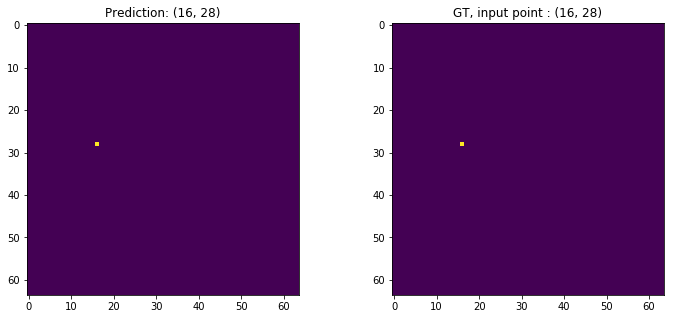

In [21]:
from torch.nn import functional as F

classic_net.eval()

dp = ds[test_random_indices[24]]
x = unsqueeze(normalize(dp[0], size=ds.canvas_size)).to(device).unsqueeze(dim=0)
y = classic_net(x)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title("Prediction: {}".format(logits_to_index(y[0, ...], ds.canvas_size)))
plt.imshow(logits_to_img(y[0, ...]))
plt.subplot(122)
plt.title("GT, input point : {}".format(dp[0]))
plt.imshow(to_img(dp[1]))


Model with deconvolutions is able to generalize on random train/test split. 
Test accuracy is 73% according to the latest measurement after 500th epoch

#### Quadrant train/test split

Same network but trained on another train/test split

In [22]:
classic_net2 = ClassicDeconvNet()

In [23]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset


batch_size = 64
num_workers = 4

train_ds = Subset(t_ds, indices=train_quadrant_indices)
train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory='cuda' in device)

test_ds = Subset(t_ds, indices=test_quadrant_indices)
test_loader = DataLoader(test_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory='cuda' in device)

In [24]:
loss = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(classic_net2.parameters(), lr=0.003, weight_decay=0.0001)


def output_transform(output):
    y_pred, y = output
    return y_pred.view(y_pred.shape[0], -1), y


metrics = {
    'avg_loss': Loss(loss, output_transform=output_transform),
    'avg_accuracy': CategoricalAccuracy(output_transform=output_transform)
}


def loss_fn(y_pred, y):    
    y_pred, y = output_transform((y_pred, y))
    return loss(y_pred, y)


trainer = create_supervised_trainer(classic_net2, optimizer=optimizer, loss_fn=loss_fn, device=device)
evaluator = create_supervised_evaluator(classic_net2, metrics=metrics, device=device)

In [25]:
from ignite.engine import Events

log_interval = 20

        
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    if engine.state.epoch % log_interval != 0:
        return
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['avg_accuracy']
    avg_loss = metrics['avg_loss']
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    if engine.state.epoch % log_interval != 0:
        return    
    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['avg_accuracy']
    avg_loss = metrics['avg_loss']
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_loss))

In [26]:
from torch.optim.lr_scheduler import StepLR

lr_scheduler = StepLR(optimizer, step_size=40, gamma=0.9)


@trainer.on(Events.EPOCH_STARTED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    # Display learning rate:
    if len(optimizer.param_groups) == 1:
        lr = float(optimizer.param_groups[0]['lr'])
    else:
        for i, param_group in enumerate(optimizer.param_groups):
            lr = float(param_group['lr'])

In [27]:
trainer.run(train_loader, max_epochs=200)

Training Results - Epoch: 20  Avg accuracy: 0.08 Avg loss: 3.19
Validation Results - Epoch: 20  Avg accuracy: 0.00 Avg loss: 18.45
Training Results - Epoch: 40  Avg accuracy: 0.31 Avg loss: 2.12
Validation Results - Epoch: 40  Avg accuracy: 0.00 Avg loss: 37.37
Training Results - Epoch: 60  Avg accuracy: 0.59 Avg loss: 1.32
Validation Results - Epoch: 60  Avg accuracy: 0.00 Avg loss: 57.16
Training Results - Epoch: 80  Avg accuracy: 0.80 Avg loss: 0.79
Validation Results - Epoch: 80  Avg accuracy: 0.01 Avg loss: 76.95
Training Results - Epoch: 100  Avg accuracy: 0.74 Avg loss: 0.79
Validation Results - Epoch: 100  Avg accuracy: 0.00 Avg loss: 99.41
Training Results - Epoch: 120  Avg accuracy: 0.84 Avg loss: 0.57
Validation Results - Epoch: 120  Avg accuracy: 0.00 Avg loss: 117.83
Training Results - Epoch: 140  Avg accuracy: 0.98 Avg loss: 0.15
Validation Results - Epoch: 140  Avg accuracy: 0.00 Avg loss: 132.19
Training Results - Epoch: 160  Avg accuracy: 0.83 Avg loss: 0.51
Validation

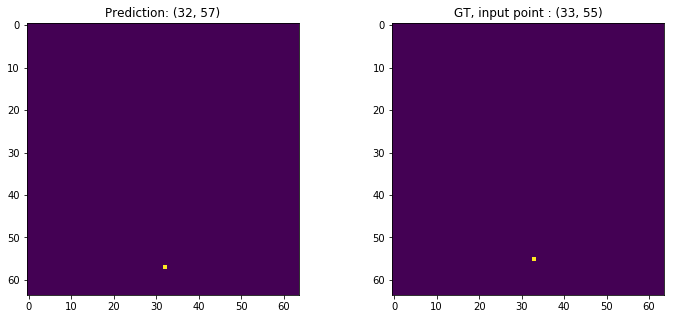

In [28]:
from torch.nn import functional as F

classic_net2.eval()

dp = ds[test_quadrant_indices[22]]
x = unsqueeze(normalize(dp[0], size=ds.canvas_size)).to(device).unsqueeze(dim=0)
y = classic_net2(x)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title("Prediction: {}".format(logits_to_index(y[0, ...], ds.canvas_size)))
plt.imshow(logits_to_img(y[0, ...]))
plt.subplot(122)
plt.title("GT, input point : {}".format(dp[0]))
plt.imshow(to_img(dp[1]))


We find out a similar result as described in the paper, that model is failed to generalize at all.

Predictions are close to the ground truth but not exactly the same.

### Model with CoordConv

In [20]:
from coord_conv import CoordConv

In [21]:
import torch.nn as nn
from torch.nn import functional as F


class CoordConvNet(nn.Module):
        
    def __init__(self, fs=2, c=1):
        super(CoordConvNet, self).__init__()        
        self.net = nn.Sequential(
            CoordConv(2, 32, kernel_size=(1, 1)),
            nn.ReLU(),            
            nn.Conv2d(32, 32, kernel_size=(1, 1)),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(1, 1)),
            nn.ReLU(),

            nn.Conv2d(64, 1, kernel_size=(1, 1)),            
        )
        
    def forward(self, x):
        return self.net(x)

#### Random train/test split

In [22]:
coord_conv_net = CoordConvNet()

x = torch.rand(4, 2, 64, 64)
y = coord_conv_net(x)
print(y.shape)

torch.Size([4, 1, 64, 64])


In [23]:
def tile(x, size):
    x = normalize(x, size=size)
    return torch.tensor(x, dtype=torch.float32).unsqueeze(dim=-1).unsqueeze(dim=-1).expand((2, size, size))


def point_to_class_index(y):
    _, c = y.view(-1).max(dim=0)
    return c 


def xy_transform(dp):
    c, p, _ = dp    
    return tile(c, size=ds.canvas_size), point_to_class_index(p)


t_ds = TransformedDataset(ds, xy_transform=xy_transform)

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

batch_size = 64
num_workers = 4

train_ds = Subset(t_ds, indices=train_random_indices)
train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory='cuda' in device)

test_ds = Subset(t_ds, indices=test_random_indices)
test_loader = DataLoader(test_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory='cuda' in device)

In [26]:
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, CategoricalAccuracy

In [27]:
loss = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(coord_conv_net.parameters(), lr=0.001, weight_decay=0.0001)


def output_transform(output):
    y_pred, y = output
    return y_pred.view(y_pred.shape[0], -1), y


metrics = {
    'avg_loss': Loss(loss, output_transform=output_transform),
    'avg_accuracy': CategoricalAccuracy(output_transform=output_transform)
}


def loss_fn(y_pred, y):    
    y_pred, y = output_transform((y_pred, y))
    return loss(y_pred, y)


trainer = create_supervised_trainer(coord_conv_net, optimizer=optimizer, loss_fn=loss_fn, device=device)
evaluator = create_supervised_evaluator(coord_conv_net, metrics=metrics, device=device)

In [28]:
from ignite.engine import Events

log_interval = 1

        
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    if engine.state.epoch % log_interval != 0:
        return
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['avg_accuracy']
    avg_loss = metrics['avg_loss']
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    if engine.state.epoch % log_interval != 0:
        return    
    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['avg_accuracy']
    avg_loss = metrics['avg_loss']
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_loss))

In [29]:
from torch.optim.lr_scheduler import StepLR

lr_scheduler = StepLR(optimizer, step_size=40, gamma=0.9)


@trainer.on(Events.EPOCH_STARTED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    # Display learning rate:
    if len(optimizer.param_groups) == 1:
        lr = float(optimizer.param_groups[0]['lr'])
    else:
        for i, param_group in enumerate(optimizer.param_groups):
            lr = float(param_group['lr'])

In [30]:
trainer.run(train_loader, max_epochs=20)

Training Results - Epoch: 1  Avg accuracy: 0.01 Avg loss: 8.12
Validation Results - Epoch: 1  Avg accuracy: 0.01 Avg loss: 8.12
Training Results - Epoch: 2  Avg accuracy: 0.05 Avg loss: 6.09
Validation Results - Epoch: 2  Avg accuracy: 0.05 Avg loss: 6.09
Training Results - Epoch: 3  Avg accuracy: 0.73 Avg loss: 3.38
Validation Results - Epoch: 3  Avg accuracy: 0.72 Avg loss: 3.38
Training Results - Epoch: 4  Avg accuracy: 0.94 Avg loss: 1.72
Validation Results - Epoch: 4  Avg accuracy: 0.96 Avg loss: 1.71
Training Results - Epoch: 5  Avg accuracy: 1.00 Avg loss: 0.71
Validation Results - Epoch: 5  Avg accuracy: 1.00 Avg loss: 0.72
Training Results - Epoch: 6  Avg accuracy: 1.00 Avg loss: 0.24
Validation Results - Epoch: 6  Avg accuracy: 1.00 Avg loss: 0.25
Training Results - Epoch: 7  Avg accuracy: 1.00 Avg loss: 0.10
Validation Results - Epoch: 7  Avg accuracy: 1.00 Avg loss: 0.10
Training Results - Epoch: 8  Avg accuracy: 1.00 Avg loss: 0.05
Validation Results - Epoch: 8  Avg accura

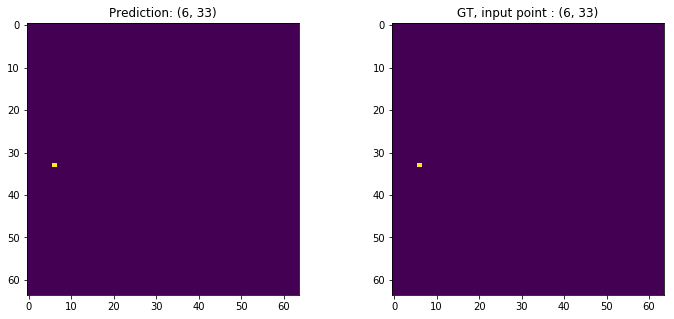

In [31]:
from torch.nn import functional as F

coord_conv_net.eval()

dp = ds[test_random_indices[29]]
x = tile(dp[0], size=ds.canvas_size).to(device).unsqueeze(dim=0)
y = coord_conv_net(x)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title("Prediction: {}".format(logits_to_index(y[0, ...], ds.canvas_size)))
plt.imshow(logits_to_img(y[0, ...]))
plt.subplot(122)
plt.title("GT, input point : {}".format(dp[0]))
plt.imshow(to_img(dp[1]))


We observe as in the paper that model learns very-very fast

#### Quadrant train/test split

Same network but trained on another train/test split

In [37]:
coord_conv_net2 = CoordConvNet()

x = torch.rand(4, 2, 64, 64)
y = coord_conv_net2(x)
print(y.shape)

torch.Size([4, 1, 64, 64])


In [38]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

batch_size = 64
num_workers = 4

train_ds = Subset(t_ds, indices=train_quadrant_indices)
train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory='cuda' in device)

test_ds = Subset(t_ds, indices=test_quadrant_indices)
test_loader = DataLoader(test_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory='cuda' in device)

In [39]:
loss = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(coord_conv_net2.parameters(), lr=0.005, weight_decay=0.0001)


def output_transform(output):
    y_pred, y = output
    return y_pred.view(y_pred.shape[0], -1), y


metrics = {
    'avg_loss': Loss(loss, output_transform=output_transform),
    'avg_accuracy': CategoricalAccuracy(output_transform=output_transform)
}


def loss_fn(y_pred, y):    
    y_pred, y = output_transform((y_pred, y))
    return loss(y_pred, y)


trainer = create_supervised_trainer(coord_conv_net2, optimizer=optimizer, loss_fn=loss_fn, device=device)
evaluator = create_supervised_evaluator(coord_conv_net2, metrics=metrics, device=device)

In [40]:
from ignite.engine import Events

log_interval = 1

        
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    if engine.state.epoch % log_interval != 0:
        return
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['avg_accuracy']
    avg_loss = metrics['avg_loss']
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    if engine.state.epoch % log_interval != 0:
        return    
    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['avg_accuracy']
    avg_loss = metrics['avg_loss']
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_loss))

In [41]:
from torch.optim.lr_scheduler import StepLR

lr_scheduler = StepLR(optimizer, step_size=2, gamma=0.9)


@trainer.on(Events.EPOCH_STARTED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    # Display learning rate:
    if len(optimizer.param_groups) == 1:
        lr = float(optimizer.param_groups[0]['lr'])
    else:
        for i, param_group in enumerate(optimizer.param_groups):
            lr = float(param_group['lr'])

In [42]:
trainer.run(train_loader, max_epochs=20)

Training Results - Epoch: 1  Avg accuracy: 0.23 Avg loss: 3.90
Validation Results - Epoch: 1  Avg accuracy: 0.00 Avg loss: 6.74
Training Results - Epoch: 2  Avg accuracy: 1.00 Avg loss: 0.12
Validation Results - Epoch: 2  Avg accuracy: 0.59 Avg loss: 1.06
Training Results - Epoch: 3  Avg accuracy: 1.00 Avg loss: 0.01
Validation Results - Epoch: 3  Avg accuracy: 1.00 Avg loss: 0.04
Training Results - Epoch: 4  Avg accuracy: 1.00 Avg loss: 0.00
Validation Results - Epoch: 4  Avg accuracy: 1.00 Avg loss: 0.02
Training Results - Epoch: 5  Avg accuracy: 1.00 Avg loss: 0.00
Validation Results - Epoch: 5  Avg accuracy: 1.00 Avg loss: 0.02
Training Results - Epoch: 6  Avg accuracy: 1.00 Avg loss: 0.00
Validation Results - Epoch: 6  Avg accuracy: 1.00 Avg loss: 0.03
Training Results - Epoch: 7  Avg accuracy: 1.00 Avg loss: 0.00
Validation Results - Epoch: 7  Avg accuracy: 1.00 Avg loss: 0.03
Training Results - Epoch: 8  Avg accuracy: 1.00 Avg loss: 0.00
Validation Results - Epoch: 8  Avg accura

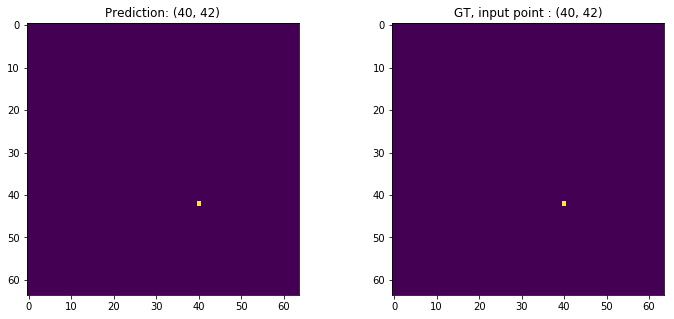

In [43]:
from torch.nn import functional as F

coord_conv_net2.eval()

dp = ds[test_quadrant_indices[205]]
x = tile(dp[0], size=ds.canvas_size).to(device).unsqueeze(dim=0)
y = coord_conv_net2(x)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title("Prediction: {}".format(logits_to_index(y[0, ...], ds.canvas_size)))
plt.imshow(logits_to_img(y[0, ...]))
plt.subplot(122)
plt.title("GT, input point : {}".format(dp[0]))
plt.imshow(to_img(dp[1]))


## Conclusion

We observe a similar behaviour of classical and coord conv networks as described in the paper:

*learning a smooth function from (x, y) to one-hot pixel is difficult for convolutional networks*
and *in striking contrast, CoordConv models attain perfect performance on both data splits* 